In [2]:
# !pip install tensorflow==2.4.1
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
# conda install tensorflow-gpu=2.3 tensorflow=2.3=mkl_py38h1fcfbd6_0

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [15]:
# Clean imports that we don't use

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
# import keras
import re
import os
import sys
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, plot_confusion_matrix



# from tensorflow.python.client import device_lib
# assert 'GPU' in str(device_lib.list_local_devices())

# # confirm Keras sees the GPU (for TensorFlow 1.X + Keras)
# from keras import backend
# assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# # confirm PyTorch sees the GPU
# from torch import cuda
# assert cuda.is_available()
# assert cuda.device_count() > 0
# print(cuda.get_device_name(cuda.current_device()))



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
!ls data/dataset/chest_xray

__MACOSX
chest_xray
test
train
val


In [17]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.3.0


In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [256, 256]
EPOCHS = 150

In [47]:
names_test = tf.io.gfile.glob(str('data/dataset/chest_xray/test/*/*'))
names_test.extend(tf.io.gfile.glob(str('data/dataset/chest_xray/test/*/*')))
labels_names_test = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1] for item
                         in tf.io.gfile.glob(str("data/dataset/chest_xray/test/*"))][:2])
print(labels_names_test)
# test_names_file, val_names_file = train_test_split(names_file, test_size=0.18)


['NORMAL' 'PNEUMONIA']


In [19]:
names_file = tf.io.gfile.glob(str('data/dataset/chest_xray/train/*/*'))

In [20]:
names_file.extend(tf.io.gfile.glob(str('data/dataset/chest_xray/train/*/*')))

In [21]:
labels_names = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1] for item
                         in tf.io.gfile.glob(str("data/dataset/chest_xray/train/*"))][:2])

In [22]:
print(labels_names)

['NORMAL' 'PNEUMONIA']


In [23]:
train_names_file, val_names_file = train_test_split(names_file, test_size=0.18)

In [24]:
number_normal = len([names for names in train_names_file if labels_names[0] in names])

In [25]:
number_pneumonia = len([names for names in train_names_file if labels_names[1] in names])

In [26]:
print("The number of images with pneumonia is {} and the number of the images without it is {}"
      .format(number_pneumonia, number_normal))

The number of images with pneumonia is 6350 and the number of the images without it is 2204


In [27]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_names_file)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_names_file)

train_count = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(train_count))

val_count = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(val_count))

Training images count: 8554
Validating images count: 1878


In [28]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"


In [29]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [30]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [31]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [32]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (256, 256, 3)
Label:  True


In [33]:
test_list_ds = tf.data.Dataset.list_files(str('data/dataset/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

In [34]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [35]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [36]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("Pneumonia")
        else:
            plt.title("Normal")
        plt.axis("off")

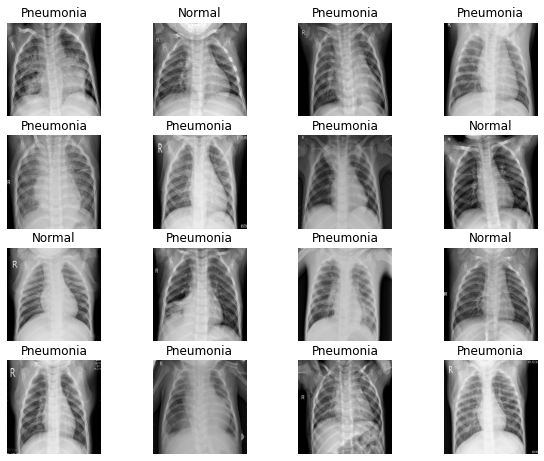

In [37]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [38]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [39]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [40]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [41]:
initial_bias = np.log([number_pneumonia/number_normal][0])
initial_bias

1.0581809216139322

In [42]:
weight_for_0 = (1 / number_normal)*(train_count)/2.0 
weight_for_1 = (1 / number_pneumonia)*(train_count)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [43]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [44]:
tf.config.list_physical_devices('GPU') 


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [45]:
history = model.fit(
    train_ds,
    steps_per_epoch=train_count // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=val_count // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/150
534/534 [==============================] - 79s 148ms/step - loss: 0.2689 - accuracy: 0.8848 - precision: 0.9712 - recall: 0.8707 - val_loss: 1.5990 - val_accuracy: 0.7457 - val_precision: 0.7457 - val_recall: 1.0000
Epoch 2/150
534/534 [==============================] - 52s 97ms/step - loss: 0.1796 - accuracy: 0.9332 - precision: 0.9773 - recall: 0.9316 - val_loss: 0.0997 - val_accuracy: 0.9669 - val_precision: 0.9912 - val_recall: 0.9642.9303 - precisi - ETA: 3s - loss: 0.1820 - accuracy: 0.932 - ETA: 0s - loss: 0.1796 - accuracy: 0.9332 - precision: 0.9773 - recall: 0.931
Epoch 3/150
534/534 [==============================] - 52s 98ms/step - loss: 0.1413 - accuracy: 0.9483 - precision: 0.9849 - recall: 0.9448 - val_loss: 0.2897 - val_accuracy: 0.8622 - val_precision: 0.8441 - val_recall: 1.0000
Epoch 4/150
534/534 [==============================] - 51s 96ms/step - loss: 0.1333 - accuracy: 0.9485 - precision: 0.9854 - recall: 0.9446 - val_loss: 0.0572 - val_accuracy: 0.981

Epoch 36/150
534/534 [==============================] - 50s 95ms/step - loss: 0.0391 - accuracy: 0.9877 - precision: 0.9960 - recall: 0.9874 - val_loss: 0.0391 - val_accuracy: 0.9915 - val_precision: 0.9971 - val_recall: 0.9914
Epoch 37/150
534/534 [==============================] - 50s 94ms/step - loss: 0.0358 - accuracy: 0.9881 - precision: 0.9976 - recall: 0.9864 - val_loss: 0.0583 - val_accuracy: 0.9813 - val_precision: 0.9985 - val_recall: 0.9763
Epoch 38/150
534/534 [==============================] - 51s 95ms/step - loss: 0.0315 - accuracy: 0.9897 - precision: 0.9973 - recall: 0.9888 - val_loss: 0.0930 - val_accuracy: 0.9882 - val_precision: 0.9971 - val_recall: 0.9871
Epoch 39/150
534/534 [==============================] - 50s 95ms/step - loss: 0.0312 - accuracy: 0.9912 - precision: 0.9976 - recall: 0.9905 - val_loss: 0.0541 - val_accuracy: 0.9915 - val_precision: 0.9921 - val_recall: 0.9964
Epoch 40/150
534/534 [==============================] - 50s 94ms/step - loss: 0.0166 - a

534/534 [==============================] - 56s 105ms/step - loss: 0.0228 - accuracy: 0.9945 - precision: 0.9989 - recall: 0.9937 - val_loss: 0.0318 - val_accuracy: 0.9915 - val_precision: 0.9914 - val_recall: 0.9971168 - accuracy: 0.9946 - precision: 0.9991 - - ETA: 6s - los
Epoch 71/150
534/534 [==============================] - 52s 97ms/step - loss: 0.0202 - accuracy: 0.9930 - precision: 0.9981 - recall: 0.9924 - val_loss: 0.0565 - val_accuracy: 0.9813 - val_precision: 0.9782 - val_recall: 0.9971
Epoch 72/150
534/534 [==============================] - 51s 96ms/step - loss: 0.0146 - accuracy: 0.9957 - precision: 0.9992 - recall: 0.9950 - val_loss: 0.0320 - val_accuracy: 0.9931 - val_precision: 0.9993 - val_recall: 0.9914
Epoch 73/150
534/534 [==============================] - 52s 97ms/step - loss: 0.0211 - accuracy: 0.9932 - precision: 0.9983 - recall: 0.9926 - val_loss: 0.0282 - val_accuracy: 0.9915 - val_precision: 0.9929 - val_recall: 0.9957
Epoch 74/150
534/534 [==================

534/534 [==============================] - 52s 97ms/step - loss: 0.0067 - accuracy: 0.9982 - precision: 0.9997 - recall: 0.9980 - val_loss: 0.0255 - val_accuracy: 0.9957 - val_precision: 0.9986 - val_recall: 0.9957
Epoch 104/150
534/534 [==============================] - 52s 97ms/step - loss: 0.0070 - accuracy: 0.9975 - precision: 0.9995 - recall: 0.9972 - val_loss: 0.0256 - val_accuracy: 0.9968 - val_precision: 1.0000 - val_recall: 0.9957
Epoch 105/150
534/534 [==============================] - 52s 97ms/step - loss: 0.0052 - accuracy: 0.9980 - precision: 0.9995 - recall: 0.9978 - val_loss: 0.0546 - val_accuracy: 0.9872 - val_precision: 1.0000 - val_recall: 0.9828ccuracy: 0.9984 - precision: 0.9998 - r - ETA: 8s - loss: 0.0049 - accuracy: 0.9983 - pre - ETA: 5s - loss: 0.0053 - acc - ETA: 0s - loss: 0.0052 - accuracy: 0.9980 - precision: 0.9995 - recall
Epoch 106/150
534/534 [==============================] - 53s 98ms/step - loss: 0.0112 - accuracy: 0.9970 - precision: 0.9989 - recall:

534/534 [==============================] - 47s 89ms/step - loss: 0.0023 - accuracy: 0.9993 - precision: 0.9998 - recall: 0.9992 - val_loss: 0.0306 - val_accuracy: 0.9947 - val_precision: 0.9971 - val_recall: 0.9957
Epoch 137/150
534/534 [==============================] - 47s 88ms/step - loss: 0.0035 - accuracy: 0.9989 - precision: 0.9998 - recall: 0.9987 - val_loss: 0.0352 - val_accuracy: 0.9947 - val_precision: 0.9986 - val_recall: 0.9943
Epoch 138/150
534/534 [==============================] - 47s 88ms/step - loss: 0.0026 - accuracy: 0.9992 - precision: 0.9997 - recall: 0.9992 - val_loss: 0.0319 - val_accuracy: 0.9963 - val_precision: 1.0000 - val_recall: 0.9950
Epoch 139/150
534/534 [==============================] - 47s 88ms/step - loss: 0.0048 - accuracy: 0.9984 - precision: 0.9998 - recall: 0.9979 - val_loss: 0.0290 - val_accuracy: 0.9957 - val_precision: 0.9986 - val_recall: 0.9957
Epoch 140/150
534/534 [==============================] - 47s 88ms/step - loss: 0.0080 - accuracy: 

In [46]:
model.save('snappy_256_modelx6')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: snappy_512_modelx2\assets
